# Data Manipulation Demo

## Annotation

In [1]:
import pandas as pd

In [2]:
ann_train = '../Data/ISIC2017/ISIC-2017_Training_Add_Part3_GroundTruth.csv'

df_train = pd.read_csv(ann_train)
df_train.head()

,image_id,nodiease,melanoma,seborrheic_keratosis
0,ISIC_0000000,1,0,0
1,ISIC_0000001,1,0,0
2,ISIC_0000002,0,1,0
3,ISIC_0000003,1,0,0
4,ISIC_0000004,0,1,0


In [3]:
# 使扩充的training set标注格式与valid、test一致
del df_train['nodiease']
df_train.to_csv('../Data/ISIC2017/ISIC-2017_Training_Aug_Part3_GroundTruth.csv', index=False)
df_train.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0,0
1,ISIC_0000001,0,0
2,ISIC_0000002,1,0
3,ISIC_0000003,0,0
4,ISIC_0000004,1,0


In [4]:
import sys
sys.path.append(r"..")

import utils

ann_train = utils.Annotation('../Data/ISIC2017/ISIC-2017_Training_Extra_Part3_GroundTruth.csv')
ann_train.df.head()

,image_id,label
0,ISIC_0000005,2
1,ISIC_0000033,2
2,ISIC_0000070,0
3,ISIC_0000076,0
4,ISIC_0000083,2


## Statistical Analysis

## Resize

randomly extracted 60 rectangular image patches from the central part of each image at different scales (1/5, 2/5, 3/5, and 4/5 of original image size) on both official and extra training images, and then resized them to 224×224 using the bilinear interpolation

Progress: 0it [00:00, ?it/s]

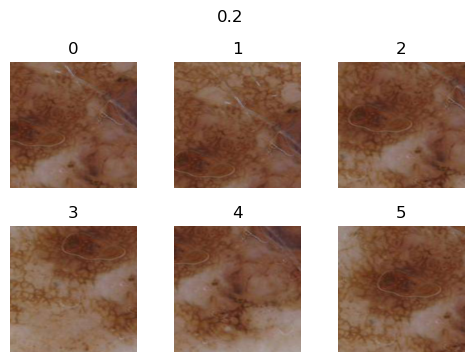

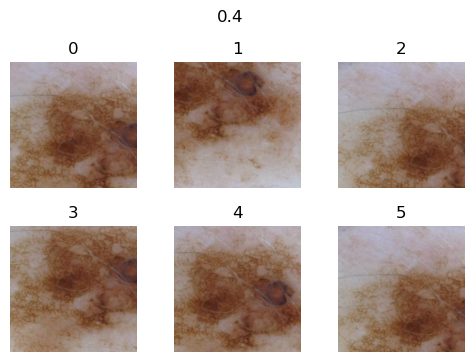

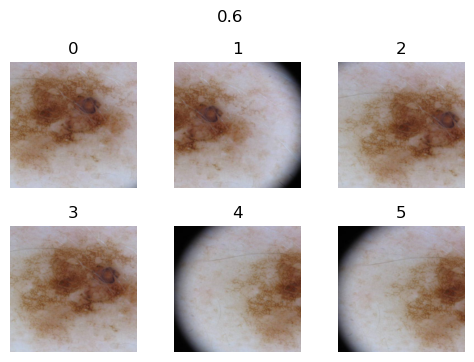

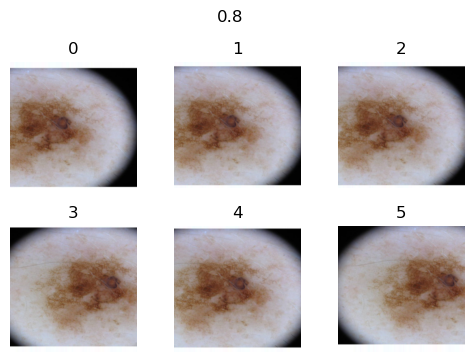

Progress: 1it [00:03,  3.15s/it]

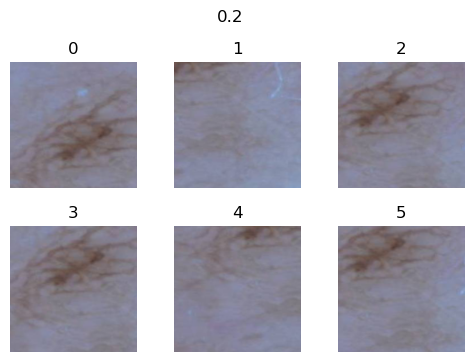

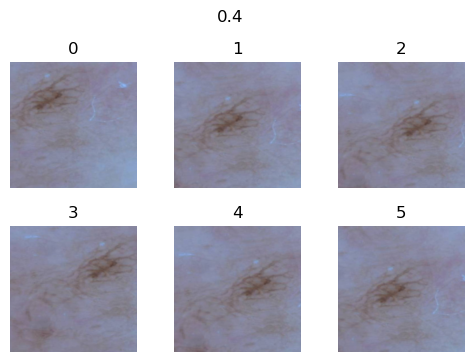

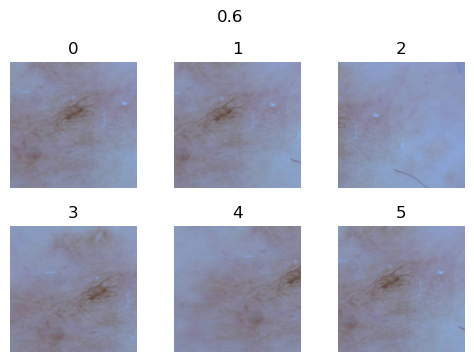

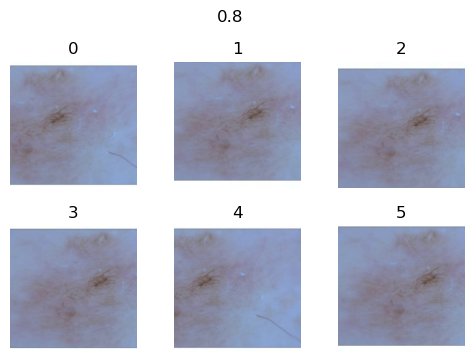

Progress: 1it [00:06,  6.47s/it]


In [42]:
from tqdm import tqdm
import os
from PIL import Image
from torchvision import transforms
import utils

img_dir = '../Data/ISIC2017/Extra'
save_dir = '../Data/ISIC2017/Training_Patch'


def rescale_crop(image, scale, sample_num):
    image_list = []
    h, w = image.size
    if scale == 1:
        trans = transforms.Resize((224, 224))
    elif scale > 1/2:
        trans = transforms.Compose([
        # transforms.RandomResizedCrop((int(h * scale), int(w * scale)), (scale, scale), ratio=(1, 1,)),
        # transforms.CenterCrop((int(h * scale + 100 * (1 - scale)), int(w * scale + 100 * (1 - scale)))),
        transforms.RandomCrop((int(h * scale), int(w * scale)), pad_if_needed=True, padding_mode='edge'),
        transforms.Resize((224, 224))
    ])
    else:
        trans = transforms.Compose([
        # transforms.RandomResizedCrop((int(h * scale), int(w * scale)), (scale, scale), ratio=(1, 1,)),
        transforms.CenterCrop((int(h - h * (1 - scale)**2), int(w - w * (1 - scale)**2))),
        transforms.RandomCrop((int(h * scale), int(w * scale)), pad_if_needed=True, padding_mode='edge'),
        transforms.Resize((224, 224))
    ])
    for _ in range(sample_num):
        img = trans(image)
        image_list.append(img)
    return image_list


for step, id in tqdm(ann_train.df['image_id'].items(), desc="Progress", leave=True):
    ori_path = os.path.join(img_dir, id + '.jpg')
    save_path = os.path.join(save_dir, id + '.jpg')
    image = Image.open(ori_path)
    for scale in [1/5, 2/5, 3/5, 4/5]:
        patches = rescale_crop(image, scale, 15)
        utils.show_samples(patches, [i for i in range(6)], 2, 3, scale, False)
        
    if step >= 1:
        break

    

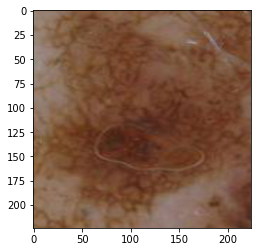

In [8]:
from matplotlib import pyplot as plt

plt.imshow(patches[0])

In [ ]:
from torch.utils import data

transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
                                ])

# augmentation transform
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(
                                          224, scale=(0.4, 1), ratio=(3/4, 4/3)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

## 